In [35]:
import netCDF4
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pathlib import Path
# Set the font size and style
plt.rcParams.update({'font.size': 11, 'font.family': 'serif'})


In [15]:
df_list = []
fp = '../../SnowEx-Data'
lidar_dir = Path(fp)
fps = list(lidar_dir.glob('*.nc'))
fps

for fp in fps:
    # open dataset
    ds = xr.open_dataset(fp)
    #get lidar flight time
    ft = pd.to_datetime(ds.attrs['lidar-flight-time'])
    # 3 days buffer
    dt = pd.Timedelta('3 days')
    # get lidar-sd and lidar-vh
    lidar_sd = ds['lidar-sd'].values.flatten()
    lidar_vh = ds['lidar-vh'].values.flatten()
    # get mean spicy snow depth for the time period
    snow_depth = ds['snow_depth'].sel(time=slice(
        ft - dt, ft + dt)).mean(dim='time').values.flatten()
    #put in dataframe
    df = pd.DataFrame({'lidar_vh': lidar_vh,
                       'lidar_sd': lidar_sd, 'snow_depth': snow_depth})
    #append to df_list
    df_list.append(df)


In [44]:
merged_df = pd.concat(df_list, ignore_index=True)
merged_df.dropna(inplace= True)

In [45]:
# Select non-negative records for lidar_sd and lidar_vh variables
merged_df = merged_df[(
    merged_df['lidar_sd'] >= 0) & (merged_df['lidar_vh'] >= 0)]


In [46]:
merged_df.describe()

,lidar_vh,lidar_sd,snow_depth
count,57953.000000,57953.000000,57953.000000
mean,3.372725,1.437220,1.079453
std,6.142007,0.571371,0.741988
min,0.000000,0.000488,0.000000
25%,0.089844,1.065918,0.518528
50%,0.169922,1.421509,0.928461
75%,4.114014,1.777344,1.457316
max,45.952393,9.360107,6.733592


In [59]:
# Define the bin edges and labels for vegetation height classes
bin_edges = [0, 0.2, 2, float('inf')]
class_labels = ['sparse vegetation', 'medium vegetation', 'dense vegetation']

# Bin the vegetation height into classes
merged_df['vegetation_class'] = pd.cut(
    merged_df['lidar_vh'], bins=bin_edges, labels=class_labels)

# Print the updated DataFrame
print(merged_df)


         lidar_vh  lidar_sd  snow_depth   vegetation_class
472      0.119873  2.065430    1.489861  sparse vegetation
473     17.820068  1.069824    1.142592   dense vegetation
474      0.099854  1.256104    0.710842  sparse vegetation
475      6.719971  1.471924    0.658272   dense vegetation
476      0.040039  1.548340    0.237811  sparse vegetation
...           ...       ...         ...                ...
111830  10.818359  0.773438    0.432283   dense vegetation
111831  23.836426  0.873047    0.590465   dense vegetation
111924  16.860474  0.234009    0.422918   dense vegetation
111925  22.931763  0.096680    0.555583   dense vegetation
111926   0.286011  0.963989    0.366277  medium vegetation

[57953 rows x 4 columns]


In [63]:
# Select records where vegetation_class is 'sparse'
merged_df[merged_df['vegetation_class'] == 'sparse vegetation']


,lidar_vh,lidar_sd,snow_depth,vegetation_class
472,0.119873,2.065430,1.489861,sparse vegetation
474,0.099854,1.256104,0.710842,sparse vegetation
476,0.040039,1.548340,0.237811,sparse vegetation
477,0.050049,1.519531,0.361456,sparse vegetation
478,0.089844,1.261719,0.514388,sparse vegetation
...,...,...,...,...
111640,0.187134,1.470215,0.156073,sparse vegetation
111729,0.171753,1.133789,0.000000,sparse vegetation
111734,0.043213,0.914551,0.354888,sparse vegetation
111735,0.187866,1.329834,0.275562,sparse vegetation


In [54]:
class_colors = {'sparse vegetation': 'red', 'medium vegetation': 'green', 'dense vegetation': 'blue'}

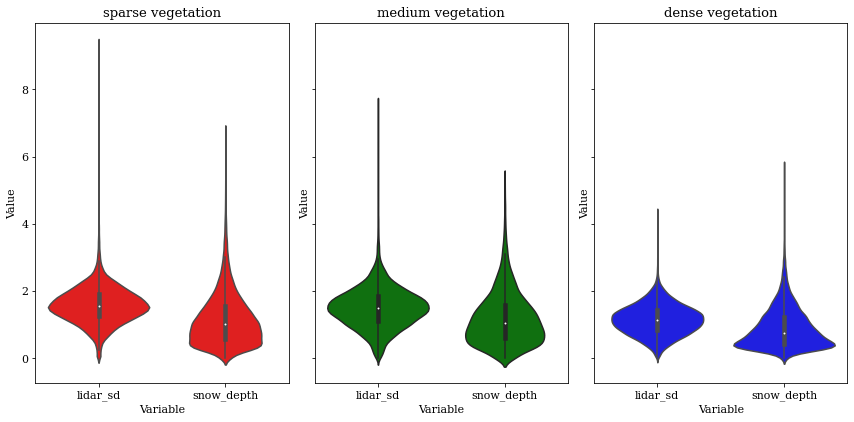

In [61]:
# Create a list to store the data for each vegetation class
class_data = []

# Iterate over vegetation classes and extract the data
for veg_class, color in class_colors.items():
    class_data.append(merged_df.loc[merged_df['vegetation_class'] == veg_class, [
                      'lidar_sd', 'snow_depth']])

# Set up the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=len(
    class_data), figsize=(12, 6), sharey=True)

# Create violin plots for each vegetation class
for i, (data, color) in enumerate(zip(class_data, class_colors.values())):
    ax = axes[i]
    sns.violinplot(data=data, palette=[color], ax=ax)
    ax.set_xlabel('Variable')
    ax.set_ylabel('Value')
    ax.set_title(list(class_colors.keys())[i])

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


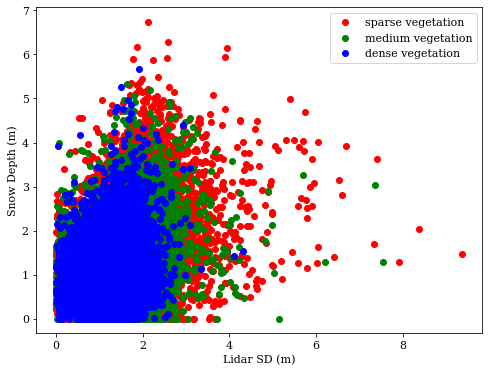

In [67]:


# Plot scatter plot
plt.figure(figsize=(8, 6))
for veg_class, color in class_colors.items():
    class_data = merged_df[merged_df['vegetation_class'] == veg_class]
    plt.scatter(class_data['lidar_sd'],
                class_data['snow_depth'], c=color, label=veg_class)

# Add labels and legend
plt.xlabel('Lidar SD (m)')
plt.ylabel('Snow Depth (m)')
plt.legend()

# Show the plot
plt.show()


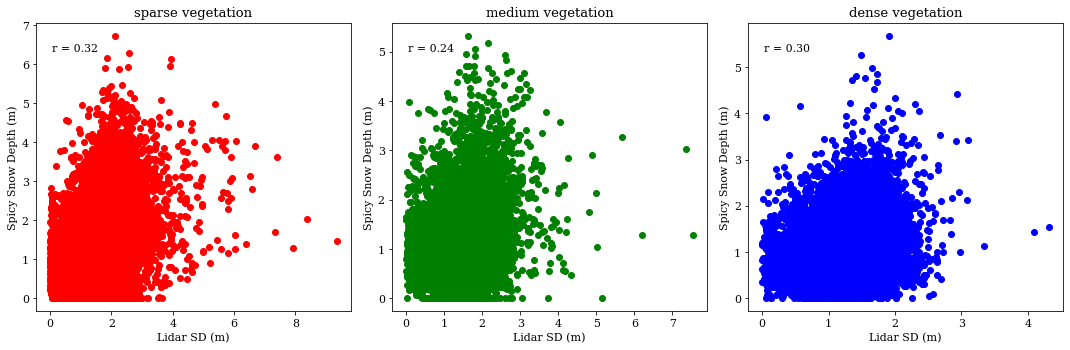

In [66]:
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Iterate over vegetation classes and plot scatter plots
for i, (veg_class, color) in enumerate(class_colors.items()):
    class_data = merged_df[merged_df['vegetation_class'] == veg_class]
    ax = axes[i]
    ax.scatter(class_data['lidar_sd'], class_data['snow_depth'], c=color)
    ax.set_xlabel('Lidar SD (m)')
    ax.set_ylabel('Spicy Snow Depth (m)')
    ax.set_title(veg_class)

    # Calculate and display the correlation (r-value)
    r_value = np.corrcoef(
        class_data['lidar_sd'], class_data['snow_depth'])[0, 1]
    ax.text(0.05, 0.9, f'r = {r_value:.2f}', transform=ax.transAxes)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


In [68]:
# dataset = xr.open_dataset(
#     '/home/naheemadebisi/geofiles1/home/NaheemAdebisi/PhD/dissertation/spicy-snow/SnowEx-Data/Banner_2020-02-18.sub.nc')
# lidar_vh_values = dataset['lidar-vh'].values.flatten()
# lidar_sd_values = dataset['lidar-sd'].values.flatten()
# snow_depth_values = dataset['snow_depth'].sel(
#     time='2020-02-17T13:49:32').values.flatten()

# # Create a DataFrame to hold the values
# banner_2020_02_18_df = pd.DataFrame({'lidar_vh': lidar_vh_values,
#                   'lidar_sd': lidar_sd_values, 'snow_depth': snow_depth_values})
# banner_2020_02_18_df
